In [1]:
import pandas as pd
import numpy as np
import json
import time
import datetime
import glob

In [2]:

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


In [3]:
# GLOBAL PARAMETERS

sus_thresh = 0.5 # malicious query probability threshold
max_seq_len = 256 # truncate to 256 symbols
max_per_source = 5000 # Training data limit per source
synth_l = 15000 # Synth sample limit

file_path = '/sus_query/incoming'


In [4]:
def timestamp_string():
    return '['+str(datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))+']'

In [5]:
def only_ascii(s):
    try:
        s.encode('ascii')
        return 1
    except:
        return 0

In [6]:
# Strip non alphanumeric characters.

def preprocess(s):
    import re
    s = s.replace('|','')
    s = re.sub(r'\W+', '', s)
    return s
    

In [7]:
# Crop a random substring from a string


def random_substring(s, min_l = 16, max_l = 128):
    l = len(s)
    sub_l = max(np.random.randint(len(s)), min_l)
    if sub_l > max_l:
        subl_l = max_l
    if l<=min_l:
        return s
    start_ = np.random.randint(0, l - sub_l)
    return  s[start_:start_+sub_l]

In [8]:
df=pd.read_csv('DNS_training_CS.csv')
df['text'] = df['text'].transform(lambda x: x[0:min(256, len(x))])

In [9]:
df = df[['label','text','source']]

In [11]:
df.sample(10)

,label,text,source
1344,0.0,Enhancements to PIT The time requested must no...,eng_sentences
31689,0.0,Please also tell us about errors and omissions.,eng_sentences
7816,1.0,725rllfgchqmdjwc7cegmz/3tcykyxon1eisseq7ull+kp...,dns2ctp
14373,0.0,Earth System Science is more than just a close...,eng_sentences
57420,1.0,api.3536b63166.3d2da7be.beacon.pacattack.xyz,cobalt_strike
30644,0.0,ITALIAN The course in Italian can be adapted t...,eng_sentences
970,0.0,After a further year of freelance work as a cl...,eng_sentences
2060,1.0,zvuf6wyaba.,dns2ctp
2811,1.0,726amjqwba.,dns2ctp
50913,1.0,0706f7274202d20576f726,hex-datagen


In [12]:
df['source'].value_counts()

eng_sentences     26006
dns2ctp           19899
cobalt_strike      7238
hex-datagen        2159
base64-datagen     2082
addr_arpa          1117
manual              750
Name: source, dtype: int64

In [13]:
# Synthesize more training data by concatenating substrings from other samples.

print(timestamp_string()+'Synthesizing Training Data.')

l = len(df)
synth_l = 15000

labels = []
strings = []

# choose two random strings and concatenate them, if at least one is malicious, the result is malicious

for i in range(synth_l):
    p1 = np.random.randint(l)
    p2 = np.random.randint(l)
    label_ = int(bool(df.iat[p1, 0] + df.iat[p1, 0]))
    string_ = random_substring(df.iat[p1, 1]) + random_substring(df.iat[p2, 1])
    labels.append(label_)
    strings.append(string_)
    
synth_data = pd.DataFrame(zip(labels, strings), columns = ['label','text'])
synth_data['source'] = 'synth'
print(timestamp_string()+'Done.')

[16/02/2024 19:56:47]Synthesizing Training Data.
[16/02/2024 19:56:48]Done.


In [21]:
df = pd.concat([df, synth_data])

In [22]:
# Select a subset of samples to work with. Specify a maximum number of samples per sample+source.

df_list = []


for i in df['source'].unique():
    df_tmp = df[df['source'] == i].copy(deep=True)
    df_tmp = df_tmp.sample(min(max_per_source, len(df_tmp)))
    df_list.append(df_tmp)
    
    
df = pd.concat(df_list)

In [ ]:
# Bring false positives from the annotation table.
# This step can be skipped, it is used for tuning the model when more data becomes available

print(timestamp_string()+'Loading false positive samples.')

false_positives = pd.read_csv('false_positives.csv')


false_positives['source'] = 'false_positives'
false_positives['label'] = 0

In [17]:
false_positive=pd.DataFrame()

In [ ]:
# skip this block if false positives frame is empty

df = pd.concat([df, false_positives[['label','text','source']]])

In [24]:
df['label'] = df['label'].transform(lambda x: int(x))

In [25]:
df['source'].value_counts()

eng_sentences     5000
cobalt_strike     5000
dns2ctp           5000
synth             5000
hex-datagen       2159
base64-datagen    2082
addr_arpa         1117
manual             750
Name: source, dtype: int64

In [26]:
df['label'].value_counts()

1    16518
0     9590
Name: label, dtype: int64

In [27]:
# Extract AlphaCapitalization Mask. "A1bb+3" -> "101100"

def alpha_mask(s):
    l = []
    for c in s:
        l.append(int(c.isalpha()))
    return l

In [28]:
# Extract UpperCase Mask. "A1bb+3CC" -> "11001111"

def uppercase_mask(s):
    l = []
    for c in s:
        l.append(int(c.upper()==c))
    return l

In [29]:
# Extract character sequence, masks and macro parameters from string.

def feature_extractor(pandas_series):
    text = pandas_series.transform(lambda x: preprocess(x))
    upper_case =  text.transform(lambda x: uppercase_mask(x))
    alpha = text.transform(lambda x: alpha_mask(x))
    text = text.transform(lambda x: ' '.join([c for c in x.lower()]))
    uniq_chars = text.transform(lambda x: len(set([c for c in x])))
    length = text.transform(lambda x: len(x))
    info = uniq_chars.transform(lambda x: np.log(x+1))*length
    return pd.DataFrame(zip(pandas_series, text, upper_case, alpha, uniq_chars, length, info), 
                        columns=['original','text','upper_mask','alpha_mask','unique','len','information'])

In [30]:
# Prepare text to feed into the model for predction.
# Tokenize, get masks, pad sequences

def preprocess_text(series, tokenizer, max_seq_len):
    X = feature_extractor(series)
    seq = X['text']
    encoded_seq = tokenizer.texts_to_sequences(seq)
    padded_seq = pad_sequences(encoded_seq, maxlen = max_seq_len)
    uppercase_seq = np.array(X['upper_mask'])
    padded_uppercase_seq = pad_sequences(uppercase_seq, maxlen = max_seq_len)
    alpha_seq = np.array(X['alpha_mask'])
    padded_alpha_seq = pad_sequences(alpha_seq, maxlen = max_seq_len)
    macro_features = X[['unique','len','information']].values
    return (padded_seq, padded_uppercase_seq, padded_alpha_seq, macro_features)

In [31]:
# Generate tokenizer for sample data

print(timestamp_string()+'Tokenizing. Preprocessing.')
seq = df['text']
label = df['label']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(seq)


[16/02/2024 20:01:17]Tokenizing. Preprocessing.


In [32]:
# Pad character sequence, alpha mask and uppercase mask. Prepare macrofeatures.

X = preprocess_text(df['text'], tokenizer, 256)
vocab_size = len(tokenizer.word_index)+1
padded_seq = X[0]
padded_uppercase_seq = X[1]
padded_alpha_seq = X[2]
macro_features = X[3]

print(timestamp_string()+'Done.')

[16/02/2024 20:01:27]Done.


In [33]:
print(timestamp_string()+'Training.')

# Build a keras model. The model has 4 inputs.
# S - character sequence (case insensitive)
# U - uppercase mask
# A - alpha mask
# M - macro parameters: number of unique characters, length and information.

inputS = keras.Input(shape = (256, ))
inputU = keras.Input(shape = (256, ))
inputA = keras.Input(shape = (256, ))
inputM = keras.Input(shape = (3, ))

# Lowercase character sequence
s = layers.Embedding(input_dim = vocab_size, output_dim=64, input_length = max_seq_len)(inputS)
s = layers.LSTM(64, activation = 'tanh')(s)
s = layers.Dense(16, activation = 'relu')(s)
s = keras.Model(inputs=inputS, outputs=s)

# Uppercase sequence
u = layers.Embedding(input_dim = 3, output_dim=16, input_length = max_seq_len)(inputU)
u = layers.LSTM(16, activation = 'tanh')(u)
u = layers.Dense(8, activation = 'relu')(u)
u = keras.Model(inputs=inputU, outputs=u)

# Alphanumeric sequence
a = layers.Embedding(input_dim = 3, output_dim=16, input_length = max_seq_len)(inputA)
a = layers.LSTM(16, activation = 'tanh')(a)
a = layers.Dense(8, activation = 'relu')(a)
a = keras.Model(inputs=inputA, outputs=a)

# Macro features
m = layers.Dense(8, activation = 'relu')(inputM)
m = layers.Dense(4, activation = 'relu')(m)
m = keras.Model(inputs=inputM, outputs = m)

combined = keras.layers.concatenate([s.output, u.output, a.output, m.output])

z = layers.Dense(16, activation="sigmoid")(combined)
z = layers.Dense(4, activation="sigmoid")(z)
z = layers.Dense(1, activation="sigmoid")(z)

model = keras.Model(inputs=[s.input, u.input, a.input, m.input], outputs=z)

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])

#model.summary()

[16/02/2024 20:01:45]Training.


In [34]:
# split into testing and training sets

from sklearn.model_selection import train_test_split
X_train, X_test, XU_train , XU_test, XA_train, XA_test, XM_train, XM_test, y_train, y_test = train_test_split(padded_seq, padded_uppercase_seq, padded_alpha_seq, macro_features, label, test_size = 0.33)

In [36]:
history = model.fit([X_train, XU_train, XA_train, XM_train], y_train, 
          validation_data = ([X_test, XU_test, XA_test, XM_test], y_test), epochs = 10)

Epoch 1/10
547/547 [==============================] - 60s 110ms/step - loss: 0.1821 - accuracy: 0.9392 - val_loss: 0.2578 - val_accuracy: 0.9106
Epoch 2/10
547/547 [==============================] - 59s 108ms/step - loss: 0.1978 - accuracy: 0.9303 - val_loss: 0.1352 - val_accuracy: 0.9595
Epoch 3/10
547/547 [==============================] - 58s 106ms/step - loss: 0.1142 - accuracy: 0.9646 - val_loss: 0.1088 - val_accuracy: 0.9656
Epoch 4/10
547/547 [==============================] - 60s 109ms/step - loss: 0.0924 - accuracy: 0.9723 - val_loss: 0.1094 - val_accuracy: 0.9647
Epoch 5/10
547/547 [==============================] - 57s 105ms/step - loss: 0.0818 - accuracy: 0.9753 - val_loss: 0.0869 - val_accuracy: 0.9748
Epoch 6/10
547/547 [==============================] - 59s 109ms/step - loss: 0.0738 - accuracy: 0.9779 - val_loss: 0.0875 - val_accuracy: 0.9753
Epoch 7/10
547/547 [==============================] - 59s 108ms/step - loss: 0.0696 - accuracy: 0.9788 - val_loss: 0.0776 - val_ac

In [37]:
import matplotlib.pyplot as plt

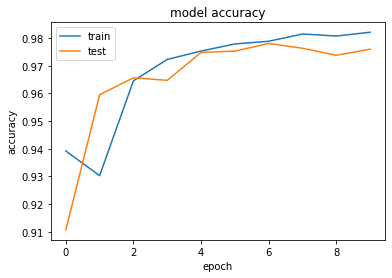

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
# at 5 epochos it yields ~98 accuracy

In [48]:
y_test_pred_prob = model.predict([X_test, XU_test, XA_test, XM_test]) # get probablities

In [44]:
from sklearn.metrics import confusion_matrix

In [49]:
y_pred = y_test_pred_prob > sus_thresh

In [50]:
CM = confusion_matrix(y_test, y_pred)

In [51]:
CM

array([[3059,  124],
       [  83, 5350]])

In [52]:
import seaborn as sns

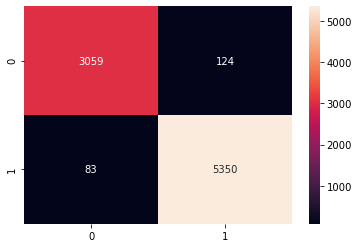

In [55]:
sns.heatmap(CM, annot=True, fmt='d')